- now we start with week 6
- from this

In [36]:
from stock_helper import *
from stock_stats import *
import scipy
from imp import reload   
import stock_helper
import stock_stats
reload(stock_helper)
reload(stock_stats)
import os


In [4]:
import warnings
 
warnings.filterwarnings('ignore')

- number of cores, set this number according to your computer

# Paths

In [10]:
HEAD_PATH = './'
DATA_PATH = HEAD_PATH + "data/stocks/"
SAVE_PATH = HEAD_PATH + "ckpt/"
TEMP_PATH = SAVE_PATH + "tmp pkl/"
OUTPUT_PATH = HEAD_PATH + 'output/'

# Parameters

## Computer Parameters

In [5]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

8

## Project Parameters

In [6]:
product_list = ["600519", "000858", "000568", "600809", "002304"]

- sample period

In [7]:
period = 4096

- get all of the days

In [8]:
import dask
from dask import compute, delayed

In [11]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days

11

- let's begin with week 6
- this week we focus on portfolio optimization which gives weights to each strategy
- we have got several signals and each signals have several strategies right now
- let's put them together now
- we can write a function to generage signal backtesting result
- first we create a directory to save the signal backtesting result
- then we can write a function to perform the job

In [12]:
os.makedirs(SAVE_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std","trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]

# Function Overwrites

## choosen good strategy from training samples and apply them on test samples

In [13]:
import random
## choosen good strategy from training samples and apply them on test samples
def get_chosen_strategy(product_list, result_dire, save_name, min_pnl_dict,min_num=20):
    random.seed(100) ## set some random numbers, so that we can select different portfolio for each time， 
    ## because if we choose all of them then the total number would be too large
    os.makedirs(SAVE_PATH+"/"+save_name, exist_ok=True)
    for dire in ["trend", "reverse"]: ## including trend and reversal stratgies
        for product in product_list: ## iterator all products
            chosen_strategy = dict() ## final chosen set
            pnl_mat = None ## chosen pnl of all strategies
            min_pnl = min_pnl_dict[product]## minimum required pnl to avoid spllipage effect
            train_stat = None ## train result
            test_stat = None ## test result
            for y in signal_list: ## iterate over the signal list
                result = load(SAVE_PATH+"/"+result_dire+"/"+product+"."+y+".pkl")[dire+".signal.stat"]
                if "train.stat" in result.keys():
                    train_stat = result["train.stat"]
                    test_stat = result["test.stat"]
                    avg_pnl = train_stat["final.result"]["avg.ret"].rolling(3, center=True).mean() ## use rolling mean of 3 results to avoid outlier
                    avg_pnl.fillna(0, inplace=True)
                    good_strat = (avg_pnl>=min_pnl) & (train_stat["final.result"]["avg.ret"]>=min_pnl)  & (train_stat["final.result"]["num"]>=min_num)
                    if sum(good_strat)==0: ## no good strategies 
                        continue;
                    elif sum(good_strat)<=5: ## too few good strategies
                        chosen_strategy[y] = good_strat
                    elif sum(good_strat)>5: ## too many good strategies
                        chosen =np.random.choice(sum(good_strat), 5, replace=False) 
                        ## just select 5 of them randomly, because for mean-variance we could not handle too many columns
                        good_strat = np.array(np.where(good_strat))[0,chosen]
                        chosen_strategy[y] = good_strat
                    if pnl_mat is None:
                        pnl_mat = train_stat["daily.pnl"][:, good_strat]
                    else:
                        pnl_mat = np.hstack((pnl_mat, train_stat["daily.pnl"][:, good_strat]))
            save((chosen_strategy, pnl_mat), SAVE_PATH+"/"+save_name+"/"+dire+"/"+product+".pkl")

## get the pnl for test samples

- now we check how it performs in the test samples

In [14]:
## get the pnl for test samples
def get_test_mat(pnl_mat, signal_name):
    for dire in ["trend","reverse"]: ## iterate for trend and reverse
        chosen_strategy, train_pnl_mat = load(SAVE_PATH+"/"+save_name+"/"+dire+"/"+product+".pkl") ## get training result
        for signal_name in chosen_strategy: ## iterate for all chosen strategies
            result = load(SAVE_PATH+"/"+result_dire+"/"+product+"."+signal_name+".pkl")[dire+".signal.stat"]
            test_stat = result["test.stat"]
            good_strat = chosen_strategy[signal_name]
            if sum(good_strat)>0:
                if pnl_mat is None:
                    pnl_mat =  test_stat["daily.pnl"][:, good_strat]
                else:
                    pnl_mat = np.hstack((pnl_mat, test_stat["daily.pnl"][:, good_strat]))
    return pnl_mat

## Portfolio Allocation - Mean Variance

In [15]:
## calculate the weight of mean-variance
def get_weight(m, s, m_star):
    s_inv = np.linalg.inv(s)
    ones = np.repeat(1, len(m))
    s_inv_ones = np.dot(s_inv , ones)
    s_inv_m = np.dot(s_inv , m)
    A = np.dot(m, s_inv_ones)
    B = np.dot(m, s_inv_m)
    C = np.dot(ones, s_inv_ones)
    D = B * C - A**2
    return ((B - m_star * A) * s_inv_ones + (m_star * C - A) * s_inv_m) / D

## page 86 of 《statistical models and methods for financial markets》
## https://quant.stackexchange.com/questions/15773/finding-expression-for-optimal-markowitz-weights

## Optimization Algorithm - Nelder_Mead 

In [16]:
import copy

'''
    Pure Python/Numpy implementation of the Nelder-Mead algorithm.
    Reference: https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method
'''


def nelder_mead(f, x_start,
                step=0.1, no_improve_thr=10e-6,
                no_improv_break=10, max_iter=0,
                alpha=1., gamma=2., rho=-0.5, sigma=0.5):
    '''
        @param f (function): function to optimize, must return a scalar score
            and operate over a numpy array of the same dimensions as x_start
        @param x_start (numpy array): initial position
        @param step (float): look-around radius in initial step
        @no_improv_thr,  no_improv_break (float, int): break after no_improv_break iterations with
            an improvement lower than no_improv_thr
        @max_iter (int): always break after this number of iterations.
            Set it to 0 to loop indefinitely.
        @alpha, gamma, rho, sigma (floats): parameters of the algorithm
            (see Wikipedia page for reference)
        return: tuple (best parameter array, best score)
    '''

    # init
    dim = len(x_start)
    prev_best = f(x_start)
    no_improv = 0
    res = [[x_start, prev_best]]

    for i in range(dim):
        x = copy.copy(x_start)
        x[i] = x[i] + step
        score = f(x)
        res.append([x, score])

    # simplex iter
    iters = 0
    while 1:
        # order
        res.sort(key=lambda x: x[1])
        best = res[0][1]

        # break after max_iter
        if max_iter and iters >= max_iter:
            return res[0]
        iters += 1

        # break after no_improv_break iterations with no improvement
        print ('...best so far:', best)

        if best < prev_best - no_improve_thr:
            no_improv = 0
            prev_best = best
        else:
            no_improv += 1

        if no_improv >= no_improv_break:
            return res[0]

        # centroid
        x0 = [0.] * dim
        for tup in res[:-1]:
            for i, c in enumerate(tup[0]):
                x0[i] += c / (len(res)-1)

        # reflection
        xr = x0 + alpha*(x0 - res[-1][0])
        rscore = f(xr)
        if res[0][1] <= rscore < res[-2][1]:
            del res[-1]
            res.append([xr, rscore])
            continue

        # expansion
        if rscore < res[0][1]:
            xe = x0 + gamma*(x0 - res[-1][0])
            escore = f(xe)
            if escore < rscore:
                del res[-1]
                res.append([xe, escore])
                continue
            else:
                del res[-1]
                res.append([xr, rscore])
                continue

        # contraction
        xc = x0 + rho*(x0 - res[-1][0])
        cscore = f(xc)
        if cscore < res[-1][1]:
            del res[-1]
            res.append([xc, cscore])
            continue

        # reduction
        x1 = res[0][0]
        nres = []
        for tup in res:
            redx = x1 + sigma*(tup[0] - x1)
            score = f(redx)
            nres.append([redx, score])
        res = nres

## Portfolio Allocation - Risk Parity

In [17]:
from scipy.optimize import minimize
## to calculate total risk
def TotalTRC(x, Cov):
    x = np.append(x, 1-np.sum(x))
    TRC = np.prod((np.dot(Cov, x), x), axis=0)
    if np.sum(x<0)>0: 
        return 10**12
    else:
        return np.sum((TRC[:, None] - TRC) ** 2)

## calculate risk parity, to minimize total risk
def risk_parity(Sub, only_diag=False, maxiter=9999):
    m = Sub.shape[1]
    Cov = np.cov(Sub, rowvar=False)
    if only_diag:
        Cov = np.diag(np.diag(Cov))
    res = minimize(functools.partial(TotalTRC, Cov=Cov), np.repeat(1/m, m-1), method="Nelder-Mead", options={'xtol': 1e-6, "maxiter": maxiter, "disp":True})
    w = np.append(res["x"], 1-np.sum(res["x"]))
    #res = nelder_mead(functools.partial(TotalTRC, Cov=Cov), np.repeat(1/m, m-1), step=1e-3, no_improve_thr=1e-05)
    #w = np.append(res[0], 1-np.sum(res[0]))
    return w

# Woking

- at first we generate result without atr

In [37]:
os.makedirs(SAVE_PATH+"/chosen_strategy_atr", exist_ok=True)
os.makedirs(SAVE_PATH+"/chosen_strategy_atr/trend", exist_ok=True)
os.makedirs(SAVE_PATH+"/chosen_strategy_atr/reverse", exist_ok=True)

## choose good strategy

In [19]:
min_pnl = dict([])
for product in product_list:
    min_pnl[product] = 0.001
get_chosen_strategy(product_list, "signal result atr", "chosen_strategy_atr", min_pnl_dict=min_pnl, min_num=10)

## save good strategy performance result

In [20]:
%%time
all_test_mat=dict([])
result_dire = "signal result atr"
save_name = "chosen_strategy_atr"
for product in product_list:
    print(product)
    test_mat = functools.reduce(get_test_mat, signal_list, None)
    all_test_mat[product] = test_mat
    
# 600519
# 000858
# 000568
# 600809
# 002304
# Wall time: 1min 10s


600519
000858
000568
600809
002304
Wall time: 1min 12s


## Plotting

- we can draw the plot

In [21]:
i = 0
result_dire = "signal result atr"
save_name = "chosen_strategy_atr"
dire = "trend"
n_product = len(product_list)
chosen_strategy, train_pnl_mat = load(SAVE_PATH+"/"+save_name+"/"+dire+"/"+product+".pkl")

In [22]:
np.shape(train_pnl_mat)

(1451, 50)

In [38]:
train_product_date = dict()
train_date_set = set()
for product in product_list:
    date_vec = np.array([])
    for file in all_dates[:6]:
        data = load(DATA_PATH+product+"/"+file)
        date = np.array([x[0:10] for x in data["date.time"]])
        next_date = np.append(date[1:],'1')
        end_day = date!=next_date
        date_vec = np.append(date_vec, date[end_day])
    train_product_date[product] = date_vec
    if len(train_date_set)==0:
        train_date_set = set(date_vec)
    else:
        train_date_set = train_date_set.intersection(set(date_vec))

In [39]:
test_product_date = dict()
test_date_set = set()
for product in product_list:
    date_vec = np.array([])
    for file in all_dates[6:]:
        data = load(DATA_PATH+product+"/"+file)
        date = np.array([x[0:10] for x in data["date.time"]])
        next_date = np.append(date[1:],'1')
        end_day = date!=next_date
        date_vec = np.append(date_vec, date[end_day])
    test_product_date[product] = date_vec
    if len(test_date_set)==0:
        test_date_set = set(date_vec)
    else:
        test_date_set = test_date_set.intersection(set(date_vec))

In [46]:
len(test_date_set)

975

In [47]:
n_days = len(train_date_set)+len(test_date_set)

In [48]:
file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))

In [49]:
train_index =dict()
test_index = dict()
for product in product_list:
    train_index[product] = list(map(lambda x: x in train_date_set, train_product_date[product]))
    test_index[product] = list(map(lambda x: x in test_date_set, test_product_date[product]))
    

In [50]:
aa = list(train_date_set)
aa.sort()
bb = list(test_date_set)
bb.sort()
dates = np.append(aa,bb)
format_dates = np.array([pd.to_datetime(d) for d in dates])
train_sample = dates<"2017"
test_sample = dates>"2017"

- Even positions in the portfolio?

600519 train sharpe:  0.3276098112661022 test sharpe:  -0.8708153064483632
000858 train sharpe:  0.30122497343930893 test sharpe:  -0.10540970076341881
000568 train sharpe:  0.47686685534082424 test sharpe:  0.3369382339183105
600809 train sharpe:  0.20528346254300883 test sharpe:  0.2953292646704876
002304 train sharpe:  0.6261338616134479 test sharpe:  0.5332711014227056
portfolio train sharpe:  0.6842928625753072 test sharpe:  0.3667652688455809


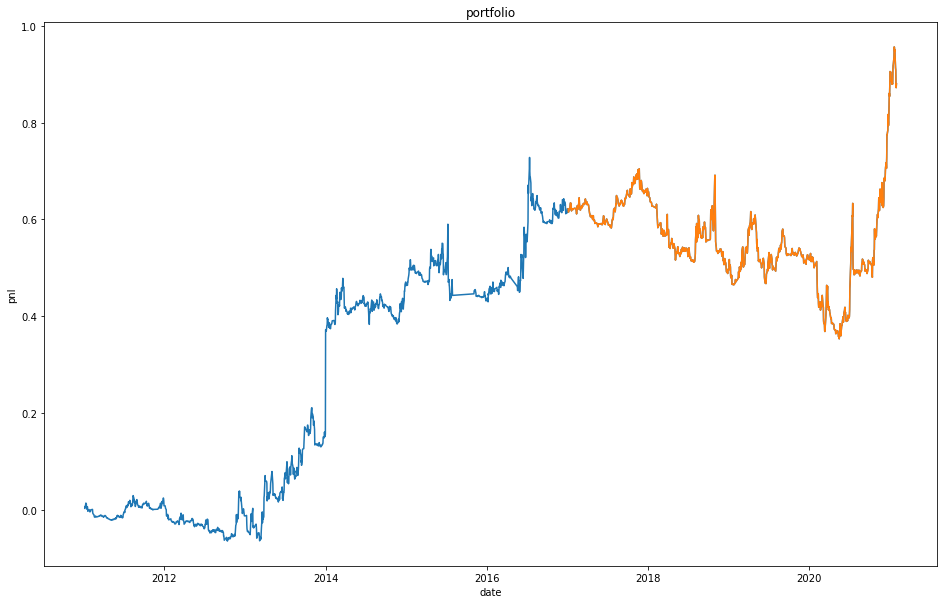

In [51]:
i = 0
result_dire = "signal result atr"
save_name = "chosen_strategy_atr"
n_product = len(product_list)
portfolio = np.zeros((n_days, n_product))
for product in product_list:
    trend_chosen_strategy, trend_pnl_mat = load(SAVE_PATH+"/"+save_name+"/trend/"+product+".pkl")
    reverse_chosen_strategy, reverse_pnl_mat = load(SAVE_PATH+"/"+save_name+"/reverse/"+product+".pkl")
    trend_pnl_mat = trend_pnl_mat[train_index[product],]
    reverse_pnl_mat = reverse_pnl_mat[train_index[product],]
    if len(trend_chosen_strategy)>0 and len(reverse_chosen_strategy)>0:
        pnl_mat =  np.hstack((trend_pnl_mat, reverse_pnl_mat))
    elif len(trend_chosen_strategy)==0:
        pnl_mat = reverse_pnl_mat
    elif len(reverse_chosen_strategy)==0:
        pnl_mat = trend_pnl_mat
    avg_train_pnl = pnl_mat.mean(axis=1)
    avg_test_pnl = all_test_mat[product].mean(axis=1)
    all_pnl = np.append(avg_train_pnl, avg_test_pnl[test_index[product]])
    #all_pnl = all_pnl/np.std(avg_train_pnl)
    i = i+1
    portfolio[:,i-1] = all_pnl
    print(product, "train sharpe: ", sharpe(avg_train_pnl),"test sharpe: ", sharpe(avg_test_pnl))

i = i+1
plt.figure(i, figsize=(16, 10))
plt.title("portfolio")
plt.xlabel("date")
plt.ylabel("pnl")
avg_portfolio = portfolio.mean(axis=1)
plt.plot(format_dates, avg_portfolio.cumsum())
plt.plot(format_dates[test_sample], avg_portfolio.cumsum()[test_sample])
print("portfolio", "train sharpe: ", sharpe(avg_portfolio[train_sample]),"test sharpe: ", sharpe(avg_portfolio[test_sample]))

# 600519 train sharpe:  0.3327687060094019 test sharpe:  -0.7690841425114907
# 000858 train sharpe:  0.33034234645039345 test sharpe:  -0.2213247154054579
# 000568 train sharpe:  0.535829890182059 test sharpe:  0.3357040755373126
# 600809 train sharpe:  0.21960019968621955 test sharpe:  0.25737306421031814
# 002304 train sharpe:  0.6024148510706134 test sharpe:  0.5609578042035095
# portfolio train sharpe:  0.6833548625253153 test sharpe:  0.352056089635403




## Portfolio Allocation Optimization among the Strategies

### Mean Variance

- at first we try using the mean-variance optimization model


- we need a function to calculate weight of each strategy for a target mean


- here the meaning of each argument is
- m: vector of average daily pnl
- s: covariance matix of daily pnl
- m.star: target daily pnl, which should be within the range of lowest and highest daily pnl

In [52]:
## calculate the weight of mean-variance
def get_weight(m, s, m_star):
    s_inv = np.linalg.inv(s)
    ones = np.repeat(1, len(m))
    s_inv_ones = np.dot(s_inv , ones)
    s_inv_m = np.dot(s_inv , m)
    A = np.dot(m, s_inv_ones)
    B = np.dot(m, s_inv_m)
    C = np.dot(ones, s_inv_ones)
    D = B * C - A**2
    return ((B - m_star * A) * s_inv_ones + (m_star * C - A) * s_inv_m) / D

## page 86 of 《statistical models and methods for financial markets》
## https://quant.stackexchange.com/questions/15773/finding-expression-for-optimal-markowitz-weights

- get daily average pnl of each strategy

In [53]:
pnl_mat = portfolio[train_sample,:]
mean_return = pnl_mat.mean(axis=0)
np.shape(pnl_mat)

## (1347, 5)

(1347, 5)

- get covariance matrix of each strategy

In [54]:
cov_return = np.cov(pnl_mat, rowvar=False)
n_point = 30
n_strat = pnl_mat.shape[1]
m_grid = np.linspace(min(mean_return), max(mean_return), n_point)
m_grid

# array([0.00017105, 0.00021274, 0.00025442, 0.00029611, 0.0003378 ,
#        0.00037948, 0.00042117, 0.00046285, 0.00050454, 0.00054623,
#        0.00058791, 0.0006296 , 0.00067128, 0.00071297, 0.00075465,
#        0.00079634, 0.00083803, 0.00087971, 0.0009214 , 0.00096308,
#        0.00100477, 0.00104646, 0.00108814, 0.00112983, 0.00117151,
#        0.0012132 , 0.00125489, 0.00129657, 0.00133826, 0.00137994])

array([0.00015207, 0.00019691, 0.00024174, 0.00028658, 0.00033142,
       0.00037625, 0.00042109, 0.00046592, 0.00051076, 0.0005556 ,
       0.00060043, 0.00064527, 0.0006901 , 0.00073494, 0.00077978,
       0.00082461, 0.00086945, 0.00091429, 0.00095912, 0.00100396,
       0.00104879, 0.00109363, 0.00113847, 0.0011833 , 0.00122814,
       0.00127298, 0.00131781, 0.00136265, 0.00140748, 0.00145232])

In [55]:
E,V = scipy.linalg.eigh(cov_return)
np.all(E > 0)
## True
## it's positive defintie

True

In [56]:
cov_grid = np.repeat(np.nan, n_point)
weight_grid = np.zeros((n_strat, n_point))


In [57]:
s_inv = np.linalg.inv(cov_return)
s_inv

# array([[ 8.21919649e+03, -3.63267360e+03, -1.51371367e+01,
#         -4.28250753e+02, -3.28033156e+02],
#        [-3.63267360e+03,  2.20095198e+04, -8.32541517e+03,
#         -2.07149931e+03, -8.31802325e+01],
#        [-1.51371367e+01, -8.32541517e+03,  2.69373627e+04,
#         -2.68819137e+03, -2.89964248e+02],
#        [-4.28250753e+02, -2.07149931e+03, -2.68819137e+03,
#          3.87625668e+03, -8.57974649e+01],
#        [-3.28033156e+02, -8.31802325e+01, -2.89964248e+02,
#         -8.57974649e+01,  7.95682030e+02]])

array([[ 8275.14463772, -4007.14781361,  -247.87384141,  -348.61088531,
         -331.42121282],
       [-4007.14781361, 22435.24506489, -7582.09924654, -1701.73891085,
          -71.42073603],
       [ -247.87384141, -7582.09924654, 24904.58499304, -2979.09313337,
         -271.78987255],
       [ -348.61088531, -1701.73891085, -2979.09313337,  3971.52996065,
          -95.88240681],
       [ -331.42121282,   -71.42073603,  -271.78987255,   -95.88240681,
          777.31588018]])

In [58]:
for i in range(1, n_point-1):
    w = get_weight(mean_return, cov_return, m_grid[i])
    cov_grid[i] = np.sqrt(np.dot(np.dot(w, cov_return), w))
    weight_grid[:,i] = w
## here we don't use the first value and last value to avoid scientific computing error

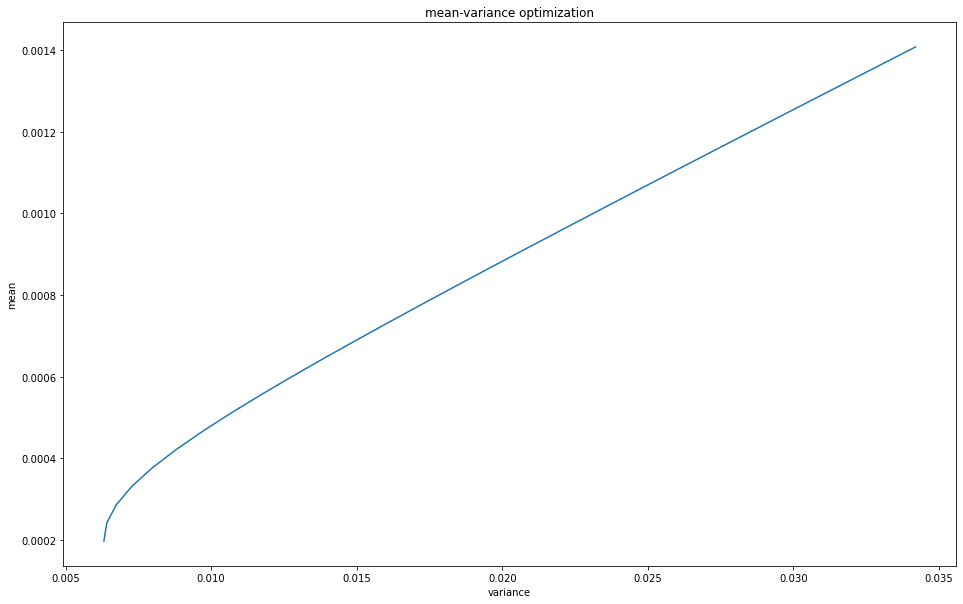

In [59]:
plt.figure(1, figsize=(16, 10))
plt.title("mean-variance optimization")
plt.xlabel("variance")
plt.ylabel("mean")
plt.plot(cov_grid, m_grid);

- to avoid using the mean return we can use risk parity model

- YQ: 选variance最小的？why

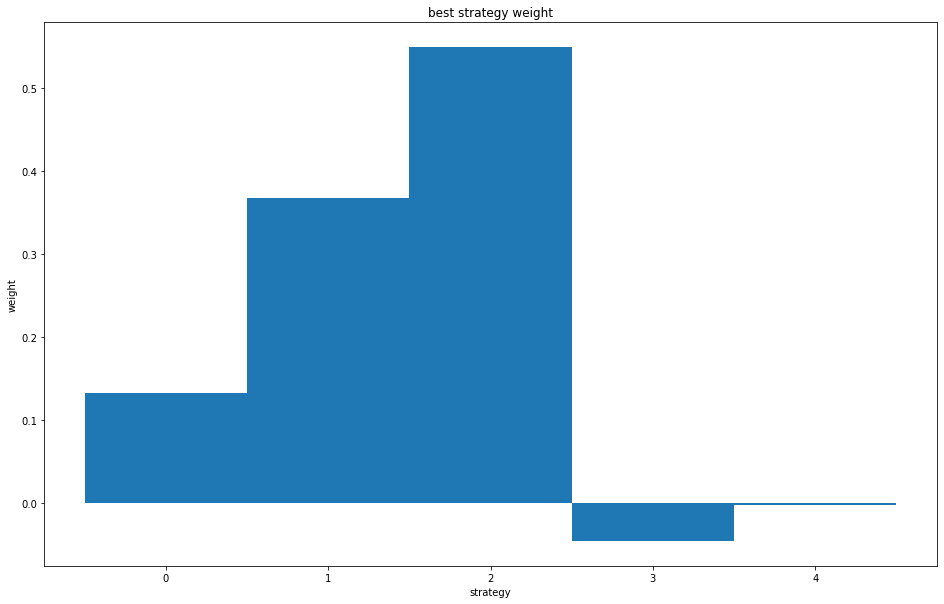

In [60]:
best_index = np.nanargmin(cov_grid)
best_weight = weight_grid[:, best_index]
best_weight = pd.Series(best_weight)
plt.figure(1, figsize=(16, 10))
plt.title("best strategy weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(best_weight.index.values, best_weight.values, width=1);

#### Avoid Short Position - can't verify due to quadprog installation failiure

- we can see that there are some negative weights
- although we can do long and short for trading commodities
- here we optimize on the strategies, which we think are good in the training set
- so it does not make sense to short a good strategy
- we also find that there are some large positive and negative weight in magnitude
- it may lead to overfitting to the training data as well
- let's see how to avoid these

- at first  we try to use this without nonnegative constraint


- we construct the matrix to be used in quadratic programming

In [61]:
A_mat = np.vstack((np.repeat(1, n_strat), mean_return)).T
n_strat

5

In [62]:
# https://pypi.org/project/quadprog/
# pip install quadprog
# need to download visual studio before running
import quadprog as qp

In [63]:
m_grid[best_index]
# 0.00021273799104813945


0.0001969070631591307

In [64]:
sol = qp.solve_qp(G=cov_return, a=np.zeros(n_strat), C=A_mat, b=np.array([1, m_grid[best_index]]), meq=2)
sol[0]

# array([ 0.14682376,  0.3164589 ,  0.59776668, -0.05434095, -0.00670839])

array([ 0.13260363,  0.36711744,  0.54925709, -0.04599722, -0.00298094])

In [65]:
sum(abs(sol[0] - best_weight) > 0.00001)

0

In [66]:
A_mat = np.vstack((np.repeat(1, n_strat), mean_return, np.diag(np.repeat(1, n_strat)))).T
A_mat.shape

(5, 7)

In [67]:
sol_nneg = qp.solve_qp(G=cov_return, a=np.zeros(n_strat), C=A_mat, b=np.hstack((1, m_grid[best_index], np.zeros(n_strat))), meq=2)
sol_nneg[0]

# array([9.97276878e-02, 4.26472195e-01, 4.73800117e-01, 9.29059931e-18,
#        0.00000000e+00])

array([1.04636186e-01, 4.13828751e-01, 4.81535063e-01, 3.55519686e-18,
       0.00000000e+00])

- we can see that there are many tiny positive values due to rounding error
- so we can use a small positive number to avoid it

In [68]:
sol_nneg = qp.solve_qp(G=cov_return, a=np.zeros(n_strat), C=A_mat, b=np.hstack((1, m_grid[best_index], np.repeat(1e-5, n_strat))), meq=2)
sol_nneg[0]

#array([3.43213413e-02, 1.47545403e-01, 6.87719696e-01, 1.00000000e-05,
#       1.30403560e-01])

array([1.04571956e-01, 4.13978755e-01, 4.81429289e-01, 1.00000000e-05,
       1.00000000e-05])

- however, now the problem is that there are too many 1e-5s, and the tenth strategy has portion of 0.59
- that may be overfitting to that strategy
- if it performs worse inthe testing samples our overall result would be very bad
- let's set a limit for the maximum portion of each strategy
- average strategy is 

In [69]:
1/n_strat

0.2

- we can set maximum to be 7%
- but then we may not get the optimal mean values
- so we need to restart the whole optimization scheme again

In [70]:
A_mat = np.vstack((np.repeat(1, n_strat), mean_return, np.diag(np.repeat(1, n_strat)), -np.diag(np.repeat(1, n_strat)))).T
cov_grid = np.repeat(np.nan, n_point)
for i in range(1, n_point-1):
    try:
        sol_nneg = qp.solve_qp(G=cov_return, a=np.zeros(n_strat), C=A_mat, 
                               b=np.hstack((1, m_grid[i], np.repeat(1e-5, n_strat), np.repeat(-0.3, n_strat))), meq=2)
    except ValueError:
        continue
    w = sol_nneg[0]
    cov_grid[i] = np.sqrt(np.dot(np.dot(w, cov_return), w))
    weight_grid[:,i] = w

In [71]:
best_index = np.nanargmin(cov_grid)
weight_grid[:, best_index]

## array([0.3       , 0.3       , 0.3       , 0.07353466, 0.02646534])

array([0.3      , 0.3      , 0.3      , 0.0744576, 0.0255424])

In [72]:
weight_grid[:, best_index]

array([0.3      , 0.3      , 0.3      , 0.0744576, 0.0255424])

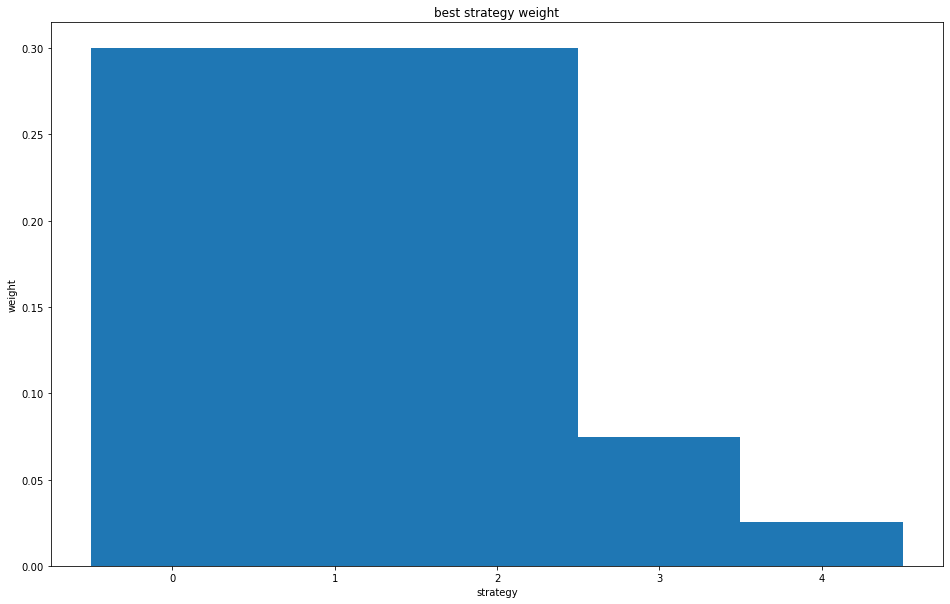

In [73]:
plt.figure(1, figsize=(16, 10))
plt.title("best strategy weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(np.linspace(0, len(weight_grid)-1, len(weight_grid)), weight_grid[:, best_index], width=1);

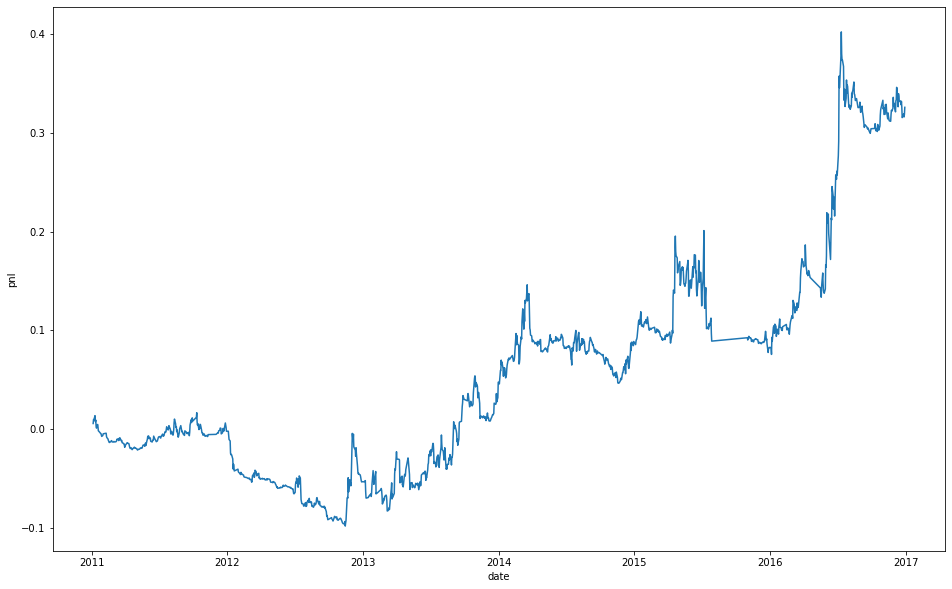

In [74]:
best_weight = weight_grid[:, best_index]
best_weight = pd.Series(best_weight)
best_weight[best_weight<1.1e-5] = 0
train_pnl = np.dot(pnl_mat, best_weight)
train_pnl = pd.Series(train_pnl)
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_pnl.cumsum());

In [75]:
sharpe(train_pnl)
## 0.5707687831152897

0.5413127117703977

##### Notice: this part might be used for other sections as well, run it first

In [76]:
test_mat = portfolio[test_sample,:]
test_pnl = np.dot(test_mat, best_weight)

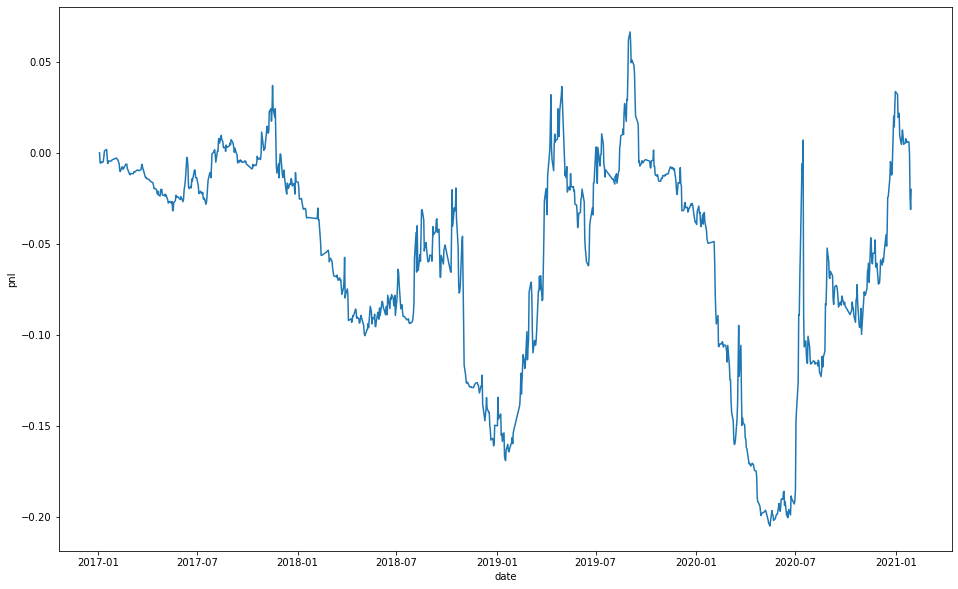

In [77]:
test_pnl = np.dot(test_mat, best_weight)
test_pnl = pd.Series(test_pnl)
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_pnl.cumsum());

In [78]:
sharpe(test_pnl)

## -0.06456897929342043

-0.040542347300288634

#### Nelder-Mead Optimization Algorithm

In [79]:
import copy

'''
    Pure Python/Numpy implementation of the Nelder-Mead algorithm.
    Reference: https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method
'''


def nelder_mead(f, x_start,
                step=0.1, no_improve_thr=10e-6,
                no_improv_break=10, max_iter=0,
                alpha=1., gamma=2., rho=-0.5, sigma=0.5):
    '''
        @param f (function): function to optimize, must return a scalar score
            and operate over a numpy array of the same dimensions as x_start
        @param x_start (numpy array): initial position
        @param step (float): look-around radius in initial step
        @no_improv_thr,  no_improv_break (float, int): break after no_improv_break iterations with
            an improvement lower than no_improv_thr
        @max_iter (int): always break after this number of iterations.
            Set it to 0 to loop indefinitely.
        @alpha, gamma, rho, sigma (floats): parameters of the algorithm
            (see Wikipedia page for reference)
        return: tuple (best parameter array, best score)
    '''

    # init
    dim = len(x_start)
    prev_best = f(x_start)
    no_improv = 0
    res = [[x_start, prev_best]]

    for i in range(dim):
        x = copy.copy(x_start)
        x[i] = x[i] + step
        score = f(x)
        res.append([x, score])

    # simplex iter
    iters = 0
    while 1:
        # order
        res.sort(key=lambda x: x[1])
        best = res[0][1]

        # break after max_iter
        if max_iter and iters >= max_iter:
            return res[0]
        iters += 1

        # break after no_improv_break iterations with no improvement
        print ('...best so far:', best)

        if best < prev_best - no_improve_thr:
            no_improv = 0
            prev_best = best
        else:
            no_improv += 1

        if no_improv >= no_improv_break:
            return res[0]

        # centroid
        x0 = [0.] * dim
        for tup in res[:-1]:
            for i, c in enumerate(tup[0]):
                x0[i] += c / (len(res)-1)

        # reflection
        xr = x0 + alpha*(x0 - res[-1][0])
        rscore = f(xr)
        if res[0][1] <= rscore < res[-2][1]:
            del res[-1]
            res.append([xr, rscore])
            continue

        # expansion
        if rscore < res[0][1]:
            xe = x0 + gamma*(x0 - res[-1][0])
            escore = f(xe)
            if escore < rscore:
                del res[-1]
                res.append([xe, escore])
                continue
            else:
                del res[-1]
                res.append([xr, rscore])
                continue

        # contraction
        xc = x0 + rho*(x0 - res[-1][0])
        cscore = f(xc)
        if cscore < res[-1][1]:
            del res[-1]
            res.append([xc, cscore])
            continue

        # reduction
        x1 = res[0][0]
        nres = []
        for tup in res:
            redx = x1 + sigma*(tup[0] - x1)
            score = f(redx)
            nres.append([redx, score])
        res = nres

### Risk Parity

In [80]:
from scipy.optimize import minimize
## to calculate total risk
def TotalTRC(x, Cov):
    x = np.append(x, 1-np.sum(x))
    TRC = np.prod((np.dot(Cov, x), x), axis=0)
    if np.sum(x<0)>0: 
        return 10**12
    else:
        return np.sum((TRC[:, None] - TRC) ** 2)

## calculate risk parity, to minimize total risk
def risk_parity(Sub, only_diag=False, maxiter=9999):
    m = Sub.shape[1]
    Cov = np.cov(Sub, rowvar=False)
    if only_diag:
        Cov = np.diag(np.diag(Cov))
    res = minimize(functools.partial(TotalTRC, Cov=Cov), np.repeat(1/m, m-1), method="Nelder-Mead", options={'xtol': 1e-6, "maxiter": maxiter, "disp":True})
    w = np.append(res["x"], 1-np.sum(res["x"]))
    #res = nelder_mead(functools.partial(TotalTRC, Cov=Cov), np.repeat(1/m, m-1), step=1e-3, no_improve_thr=1e-05)
    #w = np.append(res[0], 1-np.sum(res[0]))
    return w

- get weight of risk parity

In [81]:
parity_weight = risk_parity(pnl_mat)
parity_weight = pd.Series(parity_weight)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 146
         Function evaluations: 257


- plot the weight

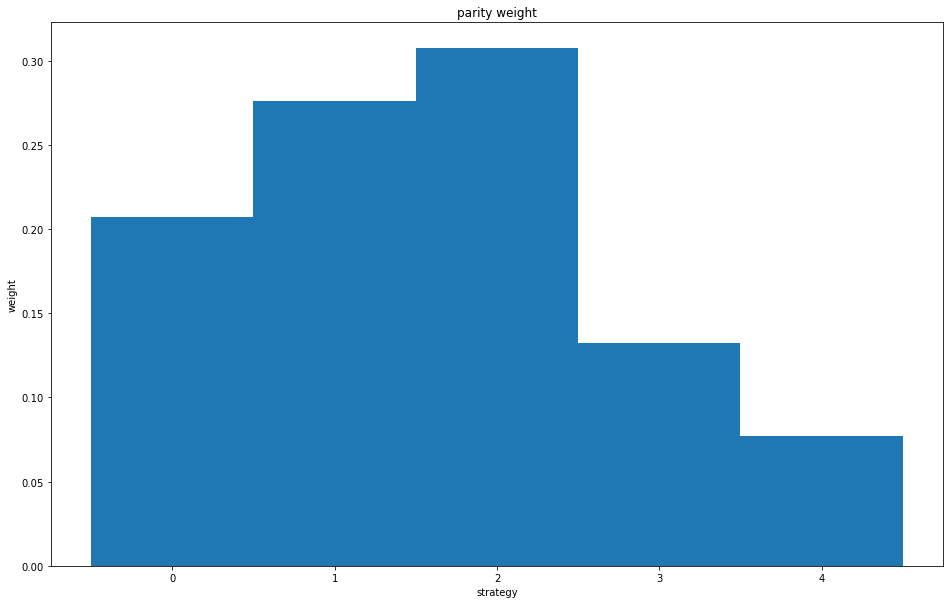

In [82]:
plt.figure(1, figsize=(16, 10))
plt.title("parity weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(parity_weight.index, parity_weight.values, width=1);

- check negative weight

In [83]:
sum(parity_weight<0)
## [1] 0

0

- check the result on training samples

In [84]:
pnl_mat.shape

(1347, 5)

In [85]:
train_parity = np.dot(pnl_mat, parity_weight)
train_parity = pd.Series(train_parity)

- and plot the final pnl

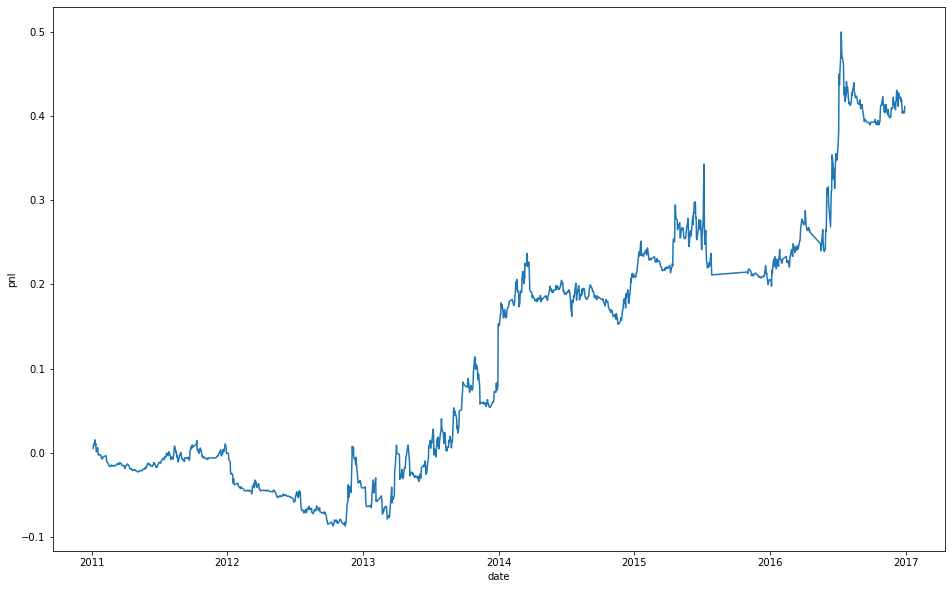

In [86]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_parity.cumsum());

- calculate the sharp ratio

In [87]:
sharpe(train_parity)
## 0.6543821041423118

0.6305240682363579

- now we check the performance on out-of-sample data

In [88]:
test_mat = portfolio[test_sample,:]

In [89]:
test_mat.shape

(975, 5)

In [90]:
test_parity = np.dot(test_mat, parity_weight)
test_parity = pd.Series(test_parity)

- and plot the final pnl

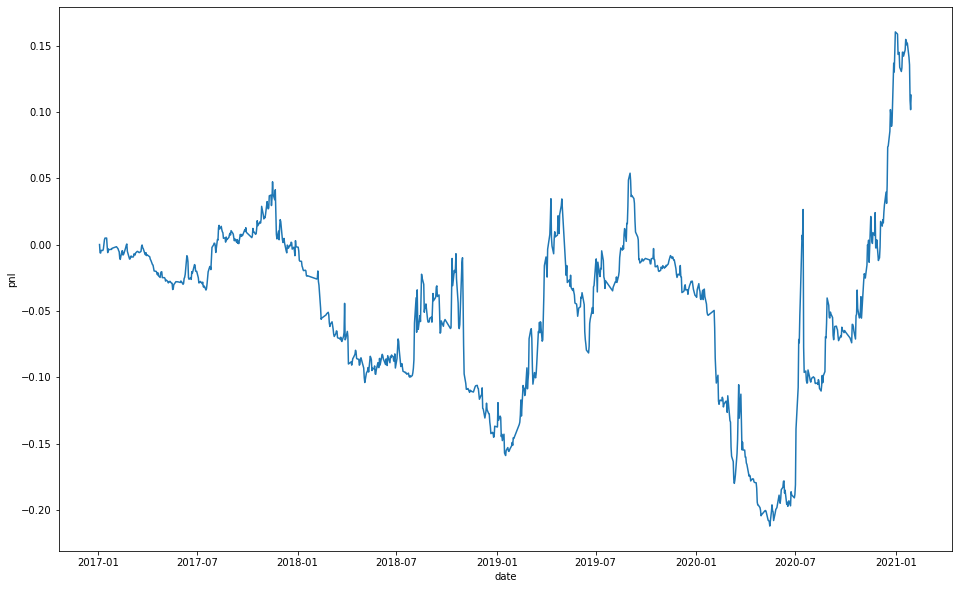

In [91]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_parity.cumsum());

- calculate the sharp ratio

In [92]:
sharpe(test_parity)

## 0.18099784210756692

0.20373598151384328

### Risk Parity using Cov Matrix with Diagnal Values Only?

- now we get back to the estimation of covariance matrix
- somebody claims that we can simply use diagonal values and set other zero
- let's try it

- get weight of risk parity

In [93]:
diagonal_weight = risk_parity(pnl_mat, only_diag=True)
diagonal_weight = pd.Series(diagonal_weight)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 141
         Function evaluations: 245


- plot the weight

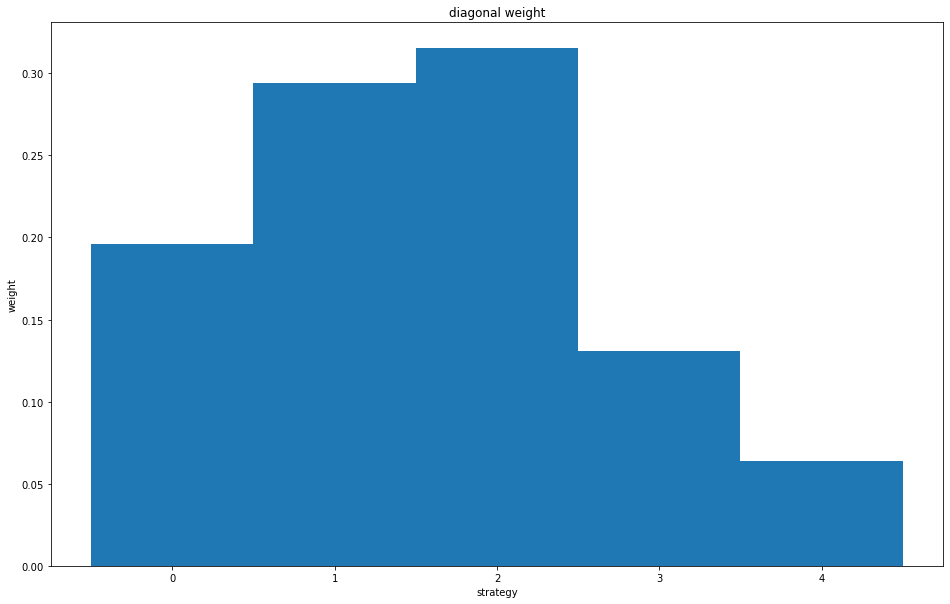

In [94]:
plt.figure(1, figsize=(16, 10))
plt.title("diagonal weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(diagonal_weight.index, diagonal_weight.values, width=1);

- check negative weight

In [95]:
sum(parity_weight<0)
## [1] 0

0

- check the result on training samples

In [96]:
train_diagonal = np.dot(pnl_mat, diagonal_weight)
train_diagonal = pd.Series(train_diagonal)

- and plot the final pnl

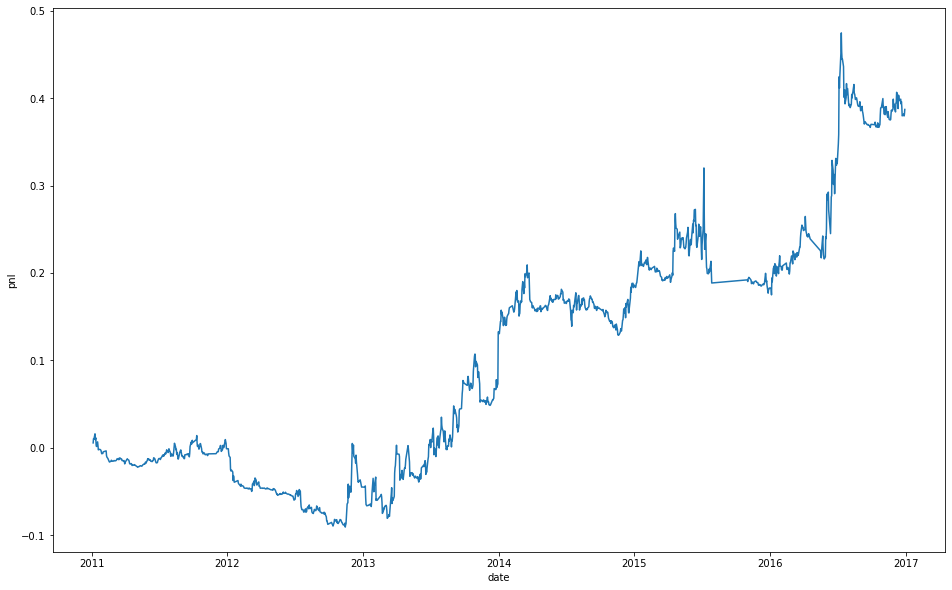

In [97]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_diagonal.cumsum());

- calculate the sharp ratio

In [98]:
sharpe(train_diagonal)
## 0.6350989637311822

0.6100388302811035

- now we check the performance on out-of-sample data

In [99]:
test_diagonal = np.dot(test_mat, diagonal_weight)
test_diagonal = pd.Series(test_diagonal)

- and plot the final pnl

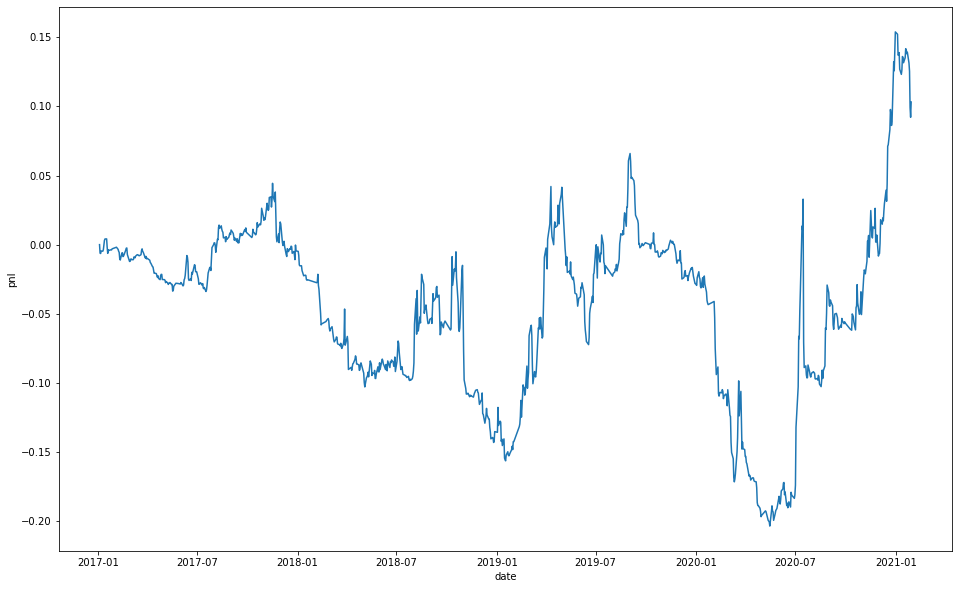

In [100]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_diagonal.cumsum());

- calculate the sharp ratio

In [101]:
sharpe(test_diagonal)
## 0.16289442574953497

0.18986610552319697

### Weight based on Sharpe Ratio

- now let's get the next weight: weight based on sharpe ratio

In [102]:
sharpe_mat = np.apply_along_axis(sharpe, 0, pnl_mat)
sharpe_weight = zero_divide(sharpe_mat, np.sum(sharpe_mat))
sharpe_weight = pd.Series(sharpe_weight)
sharpe_weight

# 0    0.164659
# 1    0.163458
# 2    0.265137
# 3    0.108662
# 4    0.298084
# dtype: float64

0    0.169122
1    0.155502
2    0.246173
3    0.105974
4    0.323229
dtype: float64

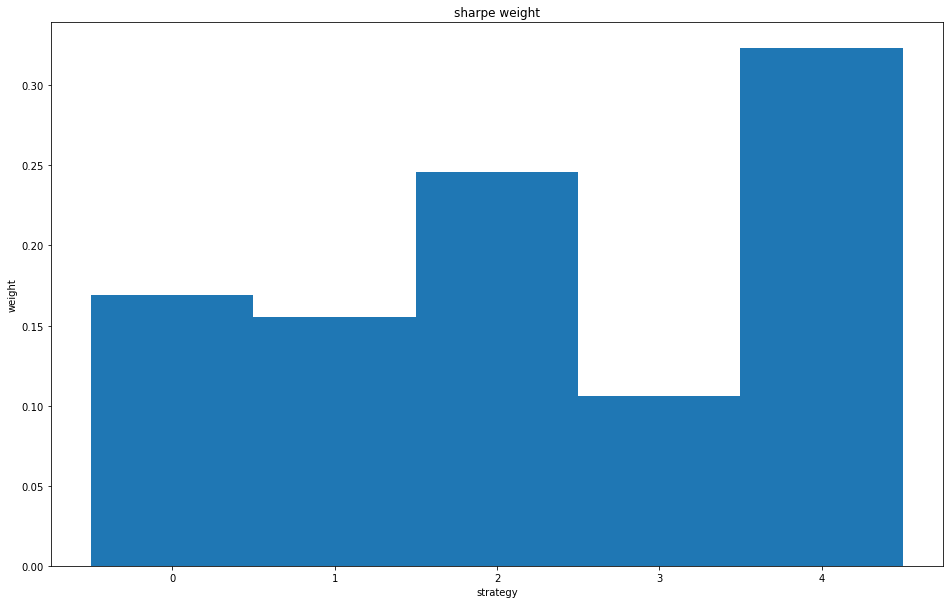

In [103]:
plt.figure(1, figsize=(16, 10))
plt.title("sharpe weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(sharpe_weight.index, sharpe_weight.values, width=1);

In [104]:
train_sharpe = np.dot(pnl_mat, sharpe_weight)
train_sharpe = pd.Series(train_sharpe)

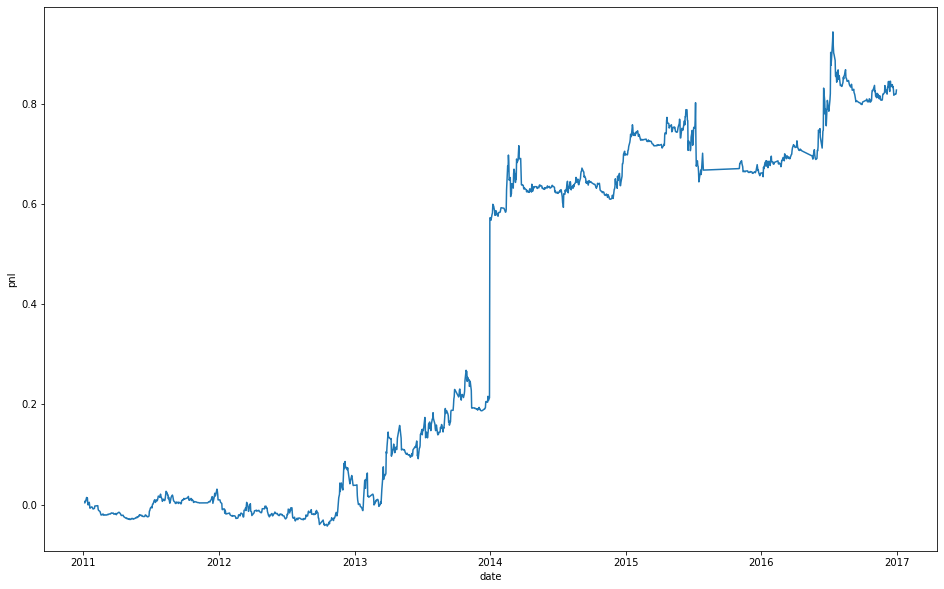

In [105]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_sharpe.cumsum());

In [106]:
sharpe(train_sharpe)
## 0.7077998665300964

0.7091653278109507

In [107]:
test_sharpe = np.dot(test_mat, sharpe_weight)
test_sharpe = pd.Series(test_sharpe)

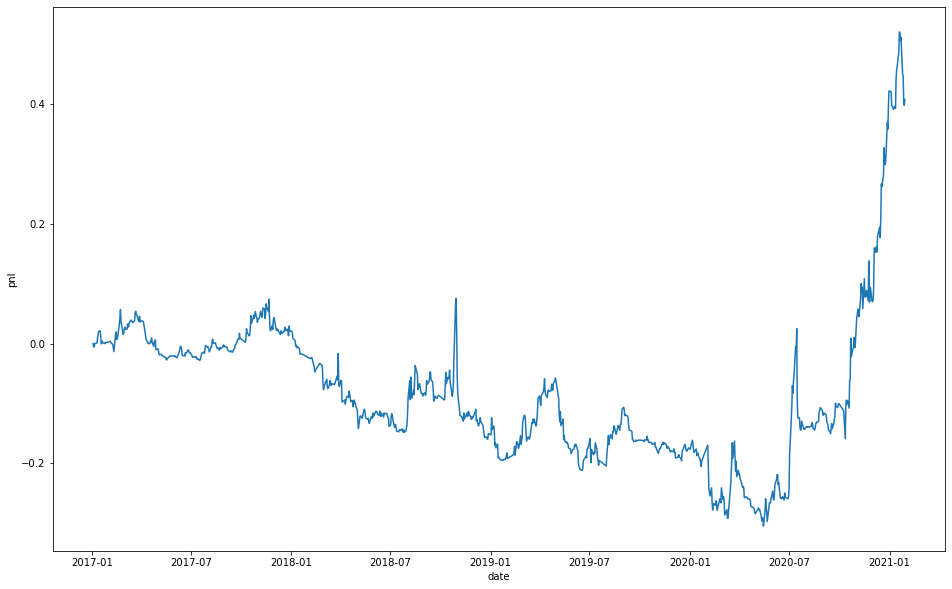

In [108]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_sharpe.cumsum());

In [109]:
sharpe(test_sharpe)
## 0.462841228806115

0.46890893814464396

### PCA

- we can see that mean-variance performs the worst while sharpe portfolio performs the best in pnl
- The last part we go to PCA

In [110]:
from sklearn.decomposition import PCA

In [111]:
pca = PCA(n_components=0.95)
pca.fit(pnl_mat)

PCA(n_components=0.95)

In [112]:
rotation = pca.components_.transpose()
rotation

# array([[ 0.06624325, -0.21233039,  0.92986393],
#        [ 0.03604633, -0.21662225,  0.22513498],
#        [ 0.0314653 , -0.1770521 ,  0.05750141],
#        [ 0.08737517, -0.92986966, -0.28129199],
#        [ 0.99281822,  0.10947866, -0.04728344]])

array([[ 0.06652321, -0.21249764,  0.92222271],
       [ 0.03364812, -0.20040449,  0.24745978],
       [ 0.03282159, -0.19610535,  0.07069749],
       [ 0.08450289, -0.92997513, -0.28449775],
       [ 0.99308835,  0.10663838, -0.04828905]])

In [113]:
train_pca = np.mean(np.matmul(pnl_mat,rotation), axis=1)

In [114]:
sharpe(train_pca)
## 0.5021681189537958

0.5338110633480124

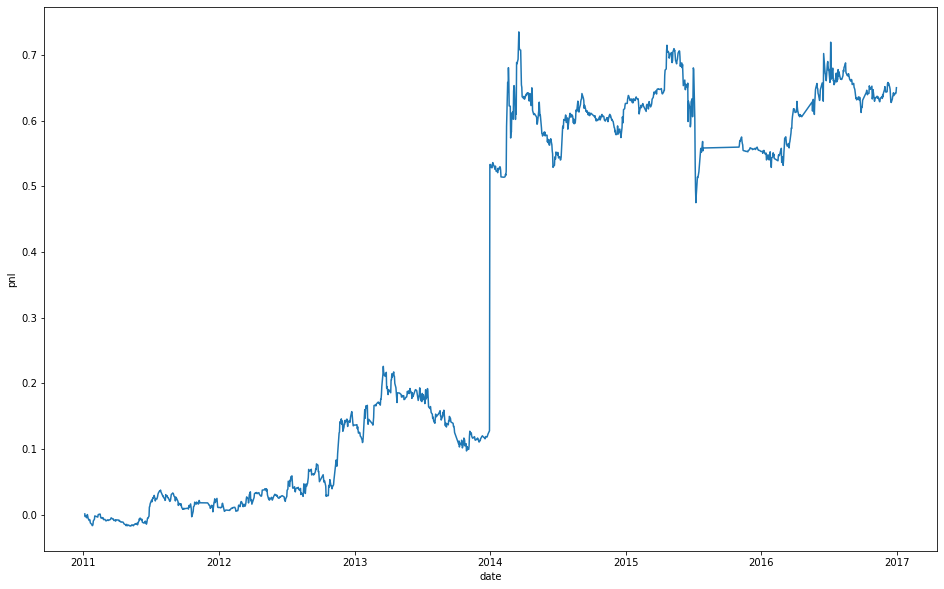

In [115]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_pca.cumsum())

In [116]:
test_pca = np.mean(np.matmul(test_mat,rotation), axis=1)

In [117]:
sharpe(test_pca)
## 0.24395056340367385

0.1966198225020412

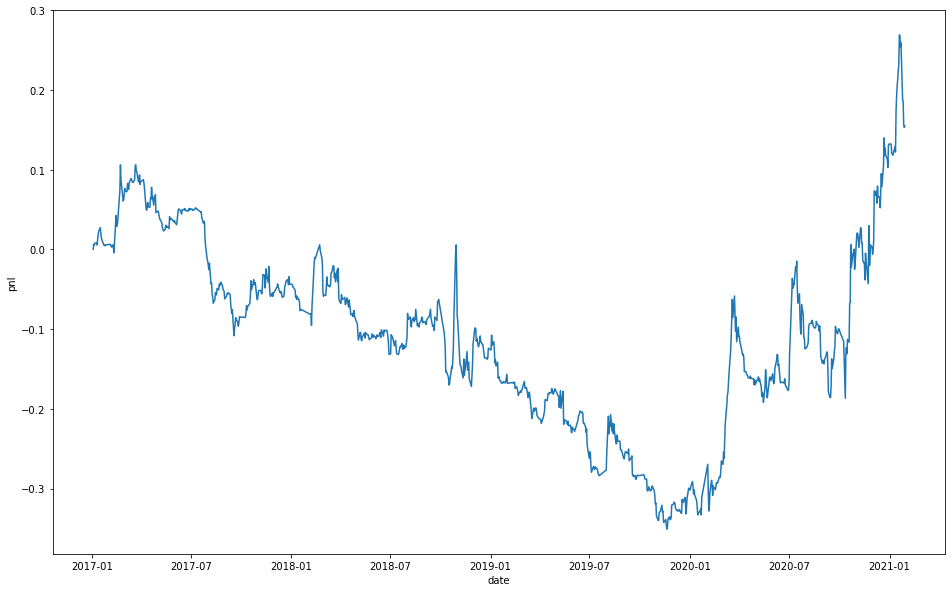

In [118]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_pca.cumsum());

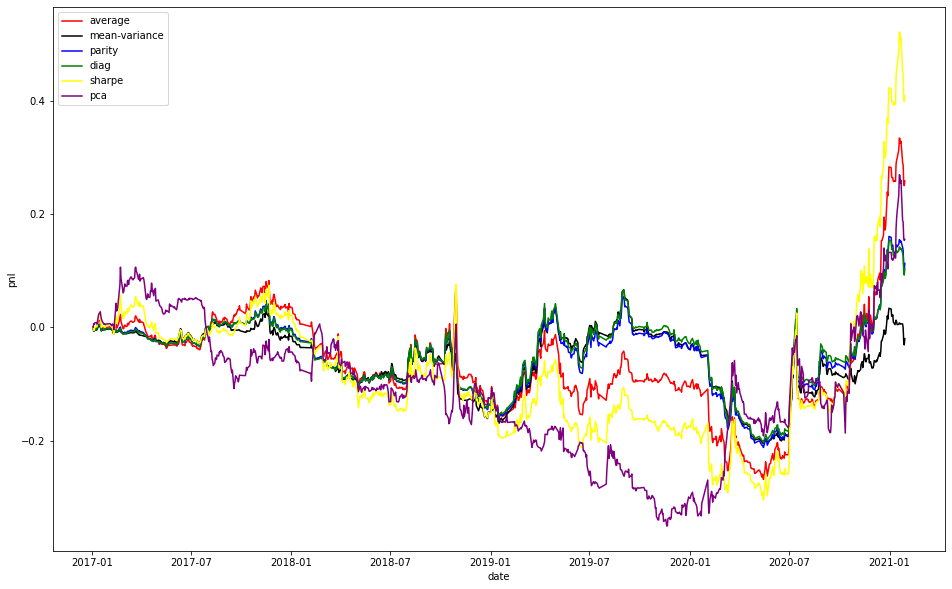

In [119]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
avg_plot, = plt.plot(format_dates[test_sample], avg_portfolio[test_sample].cumsum(), color="red", label="average");
mean_plot, = plt.plot(format_dates[test_sample], test_pnl.cumsum(), color="black", label="mean-variance");
parity_plot, = plt.plot(format_dates[test_sample], test_parity.cumsum(), color="blue", label="parity");
diag_plot, = plt.plot(format_dates[test_sample], test_diagonal.cumsum(), color="green", label="diag");
sharpe_plot, = plt.plot(format_dates[test_sample], test_sharpe.cumsum(), color="yellow", label="sharpe");
pca_plot, = plt.plot(format_dates[test_sample], test_pca.cumsum(), color="purple", label="pca");
plt.legend(handles=[avg_plot,mean_plot,parity_plot, diag_plot, sharpe_plot, pca_plot])